<img src="../images/QISKit-c.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## _*Quantum Process Tomography*_ 

The latest version of this notebook is available on https://github.com/IBM/qiskit-sdk-py/tree/master/scripts.

For more information about how to use the IBM Q experience (QX), consult the [IBM Q experience tutorials](https://quantumexperience.ng.bluemix.net/qstage/#/tutorial?sectionId=c59b3710b928891a1420190148a72cce&pageIndex=0), or check out the [community](https://quantumexperience.ng.bluemix.net/qstage/#/community).

***
### Contributors
Christopher J. Wood

## Introduction

In this notebook we demonstrate how to design and run experiments to perform quantum process tomography using QISKit, and demonstrate this using both simulators, and the IBM Quantum Experience. This is implemented similarly to [quantum state tomography](state_tomography.ipynb) example notebook [here](state_tomography.ipynb).

The functions used in this notebook to implement state tomography may be imported from the `tools.tomography` module.

#### Experiment Design

The tomography experiments demonstrated in this notebook prepend an arbitrary quantum circuit with preparation and measurements in the Pauli basis. The preparation circuits prepare the system in each of the postive and negative eigenstates of the X, Y, and Z Pauli bases, and the measurement circuits perform state tomography. For $n$-qubits this gives a total of $2^n3^{2n}$ circuits which must be run resulting in a tomographically overcomplete basis for reconstruction of the quantum process.

#### Reconstruction Methods

State reconstruction may be done using a variety of methods. In this notebook implement two simple cases, they are: 
* Least Squares Fitting 
* Fast maximum likelihood (*see [J Smolin, JM Gambetta, G Smith, Phys. Rev. Lett. 108, 070502](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.108.070502), open access: [arXiv:1106.5458](https://arxiv.org/abs/1106.5458)*).

Note that while the fast maximum likelihood method constraints the resulting channel to be positive, it does not enfore complete positivity of the final estimate.

In [1]:
# Checking the version of PYTHON; we only support 3 at the moment
import sys
if sys.version_info < (3,0):
    raise Exception("Please use Python version 3 or greater.")
import numpy as np
import time
    
# importing the QISKit
sys.path.append("../../")
from qiskit import QuantumCircuit, QuantumProgram
import Qconfig

# import tomography libary
import tools.tomography as tomo

# useful additional packages 
from tools.visualization import plot_state
from tools.qi import *

## Creating quantum program for quantum process tomography


In [2]:
Q_program = QuantumProgram()
#Q_program.set_api(Qconfig.APItoken, Qconfig.config["url"]) # set the APIToken and API url

# Creating registers
qr = Q_program.create_quantum_register("qr", 3)
cr = Q_program.create_classical_register("cr", 3)

# hadamard on qubit-0 only
had = Q_program.create_circuit("had", [qr], [cr])
had.h(qr[0])

# CNOT gate with qubit-1 control, qubit-0 target
cnot = Q_program.create_circuit("cnot", [qr], [cr])
cnot.cx(qr[1], qr[0])

# Toffoli gate with qubits-0 as target
toffoli = Q_program.create_circuit("toffoli", [qr], [cr])
toffoli.ccx(qr[2], qr[1], qr[0])

## Process tomography of a Hadamard gate

We will first demonstrate a process tomography experiment for a single qubit H gate.

### Visualization of the ideal process

Plot choi-matrix, rauli

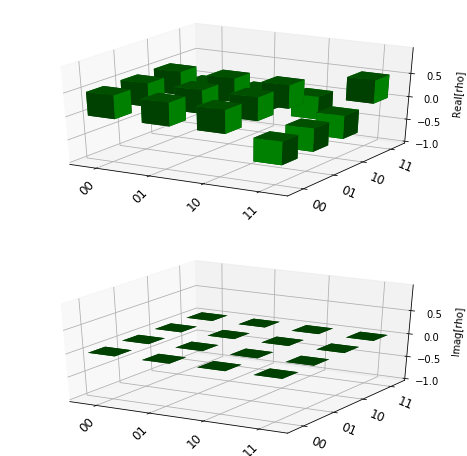

In [2]:
U_had = np.array([[1,1],[1,-1]])/np.sqrt(2)
# compute Choi-matrix from unitary
choi_had = outer(vectorize(U_had))
plot_state(choi_had)

### Simulation of process tomography experiment

Next we build the process tomography circuits (write more later)

In [4]:
backend = 'local_qasm_cpp_simulator'
shots = 5000
tomo_had = tomo.build_process_tomography_circuits(Q_program, 'had', [0], qr, cr)
Q_program.execute(tomo_had, backend=backend, shots=shots, silent=False)
had_process_data = tomo.process_tomography_data(Q_program, 'had', [0], backend=backend)

>> created process tomography circuits for "had"
running on backend: local_qasm_cpp_simulator


### Fitting the tomography data

Process Fidelity =  0.999618400753


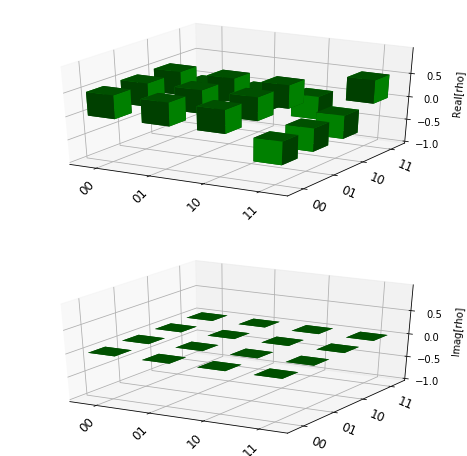

In [5]:
choi_had_fit = tomo.fit_tomography_data(had_process_data, options={'trace':2})
print('Process Fidelity = ', state_fidelity(vectorize(U_had)/2, choi_had_fit))
plot_state(choi_had_fit)


## Process tomography of a CNOT gate

We will demonstrate a process tomography experiment for a CNOT gate.

### Visualization of the ideal process

Plot choi-matrix, rauli

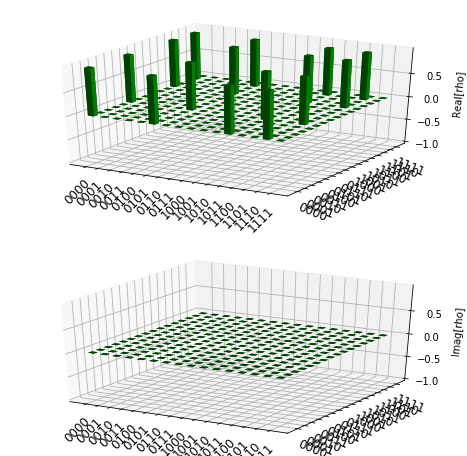

In [6]:
U_cnot = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
# compute Choi-matrix from unitary
choi_cnot = outer(vectorize(U_cnot))
plot_state(choi_cnot) 

### Simulation of process tomography experiment

Our test circuit simply consists of a quantum program of two qubits with a single gate, the CNOT gate. Note that we must include a two-qubit register to record measurement outcomes.


In [7]:
backend = 'local_qasm_cpp_simulator'
shots = 5000
tomo_cnot = tomo.build_process_tomography_circuits(Q_program, 'cnot', [0,1], qr, cr)
print('>> compiling cirucits...')
start = time.clock() # time compilation time
Q_program.execute(tomo_cnot, backend=backend, shots=shots, silent=False)
t = round(time.clock()-start, 1)
print('>> time taken:', t)
cnot_process_data = tomo.process_tomography_data(Q_program, 'cnot', [0,1], backend=backend)

>> created process tomography circuits for "cnot"
running on backend: local_qasm_cpp_simulator


### Fitting the process matrix


Now we fit the data and plot the results

Process Fidelity =  0.99858119695


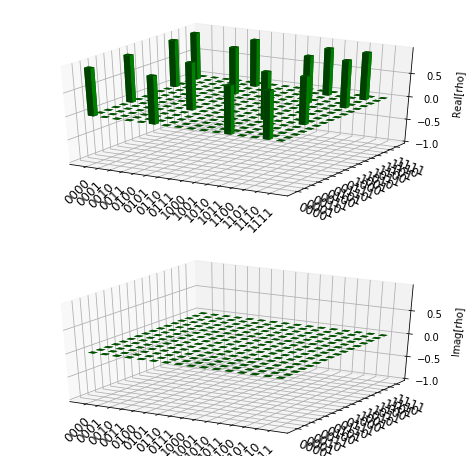

In [8]:
choi_cnot_fit = tomo.fit_tomography_data(cnot_process_data, options={'trace':4})
print('Process Fidelity = ', state_fidelity(vectorize(U_cnot)/4, choi_cnot_fit))
plot_state(choi_cnot_fit)

## Toffli Gate

Warning: compiling all 5832 measurement circuits takes a LONG time.

In [37]:
backend = 'local_qasm_cpp_simulator'
shots = 5000

tomo_toffoli = tomo.build_process_tomography_circuits(Q_program, 'toffoli', [0,1,2], qr, cr)
print('>> number of circuits:', len(tomo_toffoli))

>> created process tomography circuits for "toffoli"
>> number of circuits: 5832


In [38]:
for j in range(12):
    ri, rf = (j*500, min((j+1)*500,5832))
    print('>> Compiling & running circuits [%s,%s)' % (ri,rf))
    start = time.clock()
    Q_program.execute(tomo_toffoli[ri:rf], backend=backend, shots=shots, silent=False)
    print('time taken:', round(time.clock() - start,1))

>> Compiling & running circuits [0,500)
running on backend: local_qasm_cpp_simulator
time taken: 96.1
>> Compiling & running circuits [500,1000)
running on backend: local_qasm_cpp_simulator
time taken: 78.9
>> Compiling & running circuits [1000,1500)
running on backend: local_qasm_cpp_simulator
time taken: 80.2
>> Compiling & running circuits [1500,2000)
running on backend: local_qasm_cpp_simulator
time taken: 81.0
>> Compiling & running circuits [2000,2500)
running on backend: local_qasm_cpp_simulator
time taken: 82.7
>> Compiling & running circuits [2500,3000)
running on backend: local_qasm_cpp_simulator
time taken: 74.2
>> Compiling & running circuits [3000,3500)
running on backend: local_qasm_cpp_simulator
time taken: 83.9
>> Compiling & running circuits [3500,4000)
running on backend: local_qasm_cpp_simulator
time taken: 74.8
>> Compiling & running circuits [4000,4500)
running on backend: local_qasm_cpp_simulator
time taken: 86.1
>> Compiling & running circuits [4500,5000)
running

In [ ]:
print('>> extracting tomography data')
toffoli_process_data = tomo.process_tomography_data(Q_program, 'toffoli', [0,1,2], backend=backend)
print('time taken:', round(time.clock() - start,1))

In [ ]:
toffoli_process_data[0:10]

In [ ]:
choi_toffoli_fit = tomo.fit_tomography_data(toffoli_process_data, options={'trace':8})

In [ ]:
1+1

In [3]:
import cProfile
import pstats
Q_program = QuantumProgram()
        # Creating registers
qr = Q_program.create_quantum_register("qr", 2)
cr = Q_program.create_classical_register("cr", 2)
cnot = Q_program.create_circuit("cnot", [qr], [cr])
cnot.cx(qr[1], qr[0])
backend = 'local_qasm_cpp_simulator'
shots = 1000

In [4]:
tomo_cnot = tomo.build_process_tomography_circuits(Q_program, 'cnot', [0,1], qr, cr)
pr1 = cProfile.Profile()
pr1.enable()
Q_program.compile(tomo_cnot, backend=backend, shots=shots)
pr1.disable()

pr2 = cProfile.Profile()
pr2.enable()
Q_program.run()
pr2.disable()

>> created process tomography circuits for "cnot"


In [5]:
ps1 = pstats.Stats(pr1).sort_stats('cumulative')
ps1.print_stats()

         29116483 function calls (28772459 primitive calls) in 22.384 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000   22.391   11.196 /Users/cjwood/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2851(run_code)
    326/2    0.012    0.000   22.391   11.196 {built-in method builtins.exec}
        1    0.000    0.000   22.391   22.391 <ipython-input-4-52bd3737ce32>:4(<module>)
        1    0.004    0.004   22.391   22.391 ../../qiskit/_quantumprogram.py:694(compile)
      324    0.005    0.000   22.382    0.069 ../../qiskit/_quantumprogram.py:918(_unroller_code)
      324    0.003    0.000   22.024    0.068 ../../qiskit/qasm/_qasm.py:48(parse)
      324    0.082    0.000   16.254    0.050 ../../qiskit/qasm/_qasmparser.py:34(__init__)
      324    0.048    0.000   15.873    0.049 /Users/cjwood/anaconda/lib/python3.6/site-packages/ply/yacc.py:3214(yacc)
      324    0.011   

      326    0.001    0.000    0.001    0.000 /Users/cjwood/anaconda/lib/python3.6/codecs.py:308(__init__)
     4536    0.001    0.000    0.001    0.000 {method 'rpartition' of 'str' objects}
      324    0.001    0.000    0.001    0.000 <frozen importlib._bootstrap>:771(find_spec)
      324    0.001    0.000    0.001    0.000 ../../qiskit/extensions/standard/cx.py:36(qasm)
     1944    0.001    0.000    0.001    0.000 ../../qiskit/qasm/_node/_primarylist.py:36(size)
      324    0.000    0.000    0.001    0.000 ../../qiskit/qasm/_node/_program.py:32(__init__)
      324    0.001    0.000    0.001    0.000 ../../qiskit/qasm/_node/_qreg.py:32(__init__)
      324    0.001    0.000    0.001    0.000 ../../qiskit/extensions/standard/x.py:38(qasm)
      324    0.000    0.000    0.001    0.000 <frozen importlib._bootstrap>:698(find_spec)
      324    0.001    0.000    0.001    0.000 ../../qiskit/unroll/_unroller.py:31(__init__)
      324    0.001    0.000    0.001    0.000 {built-in method fr

In [50]:
ps2 = pstats.Stats(pr2).sort_stats('cumulative')
ps2.print_stats()

         43865807 function calls (40923779 primitive calls) in 36.586 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000   36.595   18.297 /Users/cjwood/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2851(run_code)
    326/2    0.015    0.000   36.595   18.297 {built-in method builtins.exec}
        1    0.000    0.000   36.595   36.595 <ipython-input-23-3f99d13df6a2>:3(<module>)
        1    0.011    0.011   36.595   36.595 ../../qiskit/_quantumprogram.py:694(compile)
      324    0.006    0.000   36.578    0.113 ../../qiskit/_quantumprogram.py:918(_unroller_code)
      324    0.003    0.000   28.631    0.088 ../../qiskit/qasm/_qasm.py:48(parse)
      324    0.134    0.000   22.082    0.068 ../../qiskit/qasm/_qasmparser.py:34(__init__)
      324    0.071    0.000   21.586    0.067 /Users/cjwood/anaconda/lib/python3.6/site-packages/ply/yacc.py:3214(yacc)
      324    0.021  

    12960    0.004    0.000    0.004    0.000 /Users/cjwood/anaconda/lib/python3.6/site-packages/ply/lex.py:722(<lambda>)
     1620    0.003    0.000    0.004    0.000 ../../qiskit/qasm/_node/_universalunitary.py:33(__init__)
    24948    0.004    0.000    0.004    0.000 <frozen importlib._bootstrap>:410(has_location)
      324    0.004    0.000    0.004    0.000 {built-in method posix.urandom}
      324    0.002    0.000    0.004    0.000 ../../qiskit/qasm/_qasmparser.py:450(p_qreg_decl)
      324    0.004    0.000    0.004    0.000 /Users/cjwood/anaconda/lib/python3.6/site-packages/ply/yacc.py:1474(__init__)
      324    0.002    0.000    0.004    0.000 ../../qiskit/qasm/_qasmparser.py:472(p_creg_decl)
      324    0.001    0.000    0.004    0.000 <frozen importlib._bootstrap_external>:1102(_legacy_get_spec)
      324    0.002    0.000    0.004    0.000 <frozen importlib._bootstrap>:159(_get_module_lock)
      648    0.001    0.000    0.004    0.000 /Users/cjwood/anaconda/lib/python3

|ncalls | tottime | cumtime | function |
| --- | --- | --- | --- |
| 324  |  0.003  | 28.631 |_qasm.py(parse) -> qasmparser |
| 324  | 0.134 | 22.082 | qasmparser.(init) -> yacc | 
| 324  |  0.001 | 6.545  |qasmparser.py(parse) ->yacc |
| 324  | 0.001 | 7.911 | unroller.execute -> _process_gate -> deepcopy |
| 8100 |  0.085 |  7.561 | _unroller._process_gate |
| 2219400 / 8100 | 2.911 | 7.416 | deepcopy |

In [44]:
ps3 = pstats.Stats(pr3).sort_stats('cumulative')
ps3.print_stats()

         44217907 function calls (41278255 primitive calls) in 43.806 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000   43.818   21.909 /Users/cjwood/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2851(run_code)
    326/2    0.015    0.000   43.818   21.909 {built-in method builtins.exec}
        1    0.003    0.003   43.818   43.818 <ipython-input-25-59996384126b>:3(<module>)
        1    0.046    0.046   43.815   43.815 ../../qiskit/_quantumprogram.py:943(run)
      324    0.007    0.000   36.533    0.113 ../../qiskit/_quantumprogram.py:899(_dag2json)
      324    0.003    0.000   28.896    0.089 ../../qiskit/qasm/_qasm.py:48(parse)
      324    0.129    0.000   19.687    0.061 ../../qiskit/qasm/_qasmparser.py:34(__init__)
      324    0.071    0.000   19.197    0.059 /Users/cjwood/anaconda/lib/python3.6/site-packages/ply/yacc.py:3214(yacc)
      324    0.019    0.000  

     1296    0.006    0.000    0.006    0.000 {method 'fileno' of '_io.BufferedReader' objects}
      972    0.002    0.000    0.006    0.000 /Users/cjwood/anaconda/lib/python3.6/inspect.py:458(unwrap)
      648    0.006    0.000    0.006    0.000 /Users/cjwood/anaconda/lib/python3.6/warnings.py:428(__init__)
      648    0.002    0.000    0.006    0.000 ../../qiskit/unroll/_unroller.py:197(_process_measure)
    21060    0.006    0.000    0.006    0.000 <frozen importlib._bootstrap>:208(_verbose_message)
     8100    0.006    0.000    0.006    0.000 ../../qiskit/unroll/_unroller.py:143(<listcomp>)
      324    0.005    0.000    0.005    0.000 /Users/cjwood/anaconda/lib/python3.6/selectors.py:208(__init__)
     1296    0.005    0.000    0.005    0.000 {built-in method builtins.sorted}
     7776    0.004    0.000    0.005    0.000 ../../qiskit/qasm/_node/_expressionlist.py:36(size)
      324    0.002    0.000    0.005    0.000 ../../qiskit/qasm/_qasmparser.py:296(p_magic)
      324    0.

|ncalls | tottime | cumtime | function |
| --- | --- | --- | --- |
| 324  | 0.007 | 36.5 | _quantumprogram(_dag2json) | 
|324 |0.003 | 28.896  | _qasm.py(parse) -> qasmparser | 
|324 |0.129 | 19.687  | _qasmparser.py(init) -> yacc|
|324 | 0.001 | 9.205| _qasmparser.py(parse) -> yacc|

In [14]:
from qiskit.simulators._simulatortools import single_gate_matrix

In [17]:
single_gate_matrix('u2',(0,0))

array([[ 0.70710678+0.j, -0.70710678-0.j],
       [ 0.70710678+0.j,  0.70710678+0.j]])

In [18]:
single_gate_matrix('u2',(0,np.pi))

array([[ 0.70710678 +0.00000000e+00j,  0.70710678 -8.65956056e-17j],
       [ 0.70710678 +0.00000000e+00j, -0.70710678 +8.65956056e-17j]])